In [1]:
import numpy as np
import import_ipynb
from lib.draw import board_to_svg, pit_numbering
from IPython.display import SVG

importing Jupyter notebook from /home/nikita/Code/Thesis/source/lib/draw.ipynb


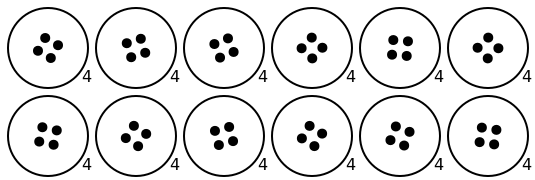

In [2]:
board = np.full((2, 6), 4)
SVG(board_to_svg(board, True))

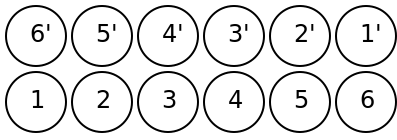

In [3]:
pit_numbering

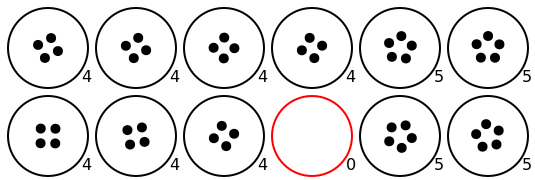

In [4]:
board = np.array([[4, 4, 4, 4, 5, 5], [4, 4, 4, 0, 5, 5],])
SVG(board_to_svg(board, True, highlight=[(1, 3)]))

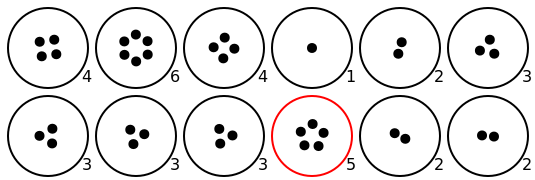

In [5]:
board = np.array([[4, 6, 4, 1, 2, 3], [3, 3, 3, 5, 2, 2],])
SVG(board_to_svg(board, True, highlight=[(1, 3)]))

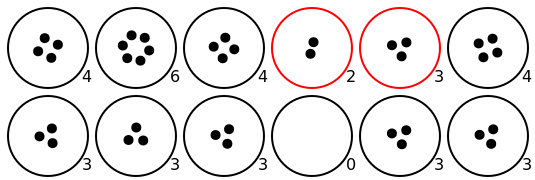

In [6]:
board = np.array([[4, 6, 4, 2, 3, 4], [3, 3, 3, 0, 3, 3],])
SVG(board_to_svg(board, True, highlight=[(0, 3), (0, 4)]))

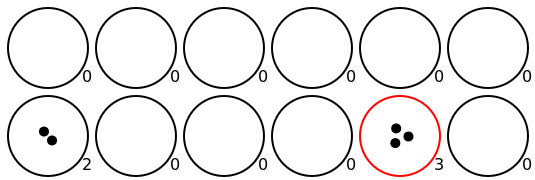

In [7]:
board = np.array([[0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 3, 0],])
SVG(board_to_svg(board, True, highlight=[(1, 4)]))

In [8]:
import numpy as np
import itertools
from typing import List, Dict, Set, Optional, Tuple

In [9]:
from dataclasses import dataclass, field


@dataclass
class Game:
    # a 2x6 matrix containing the number of seeds in each pits
    pits: np.array = field(default_factory=lambda: np.ones(6 * 2, dtype=int) * 4)
    # 0 for South and 1 for North
    current_player: int = 0
    # the number of seeds captured by each player
    captures: np.array = field(default_factory=lambda: np.zeros(2, dtype=int))

In [10]:
class Game(Game):
    ...

    @property
    def view_from_current_player(self) -> List[int]:
        """Returns the board as seen by a player"""
        if self.current_player == 0:
            return self.pits
        else:
            return np.roll(self.pits, 6)

    @property
    def current_player_pits(self) -> List[int]:
        """Returns a 6-vector containing the pits owned by the current player"""
        if self.current_player == 0:
            return self.pits[:6]
        else:
            return self.pits[6:]

    @property
    def current_opponent(self) -> int:
        return (self.current_player + 1) % 2

    @property
    def adverse_pits_idx(self) -> List[int]:
        """Returns the indices in the `self.pits` array owned by the opposing player"""
        if self.current_player == 1:
            return list(range(6))
        else:
            return list(range(6, 6 * 2))

In [11]:
class Game(Game):
    ...

    @property
    def legal_actions(self) -> List[int]:
        """Returns a list of indices for each legal action for the current player"""
        our_pits = self.current_player_pits
        # Return every pit of the player that contains some seeds
        return [x for x in range(6) if our_pits[x] != 0]

    @property
    def game_finished(self) -> bool:
        # Does the current player has an available move ?
        no_moves_left = np.sum(self.current_player_pits) == 0

        # Has one player captured more than half the total seeds ?
        HALF_SEEDS = 24  # (there are 2*6*4=48 seeds in total)
        enough_captures = self.captures[0] > HALF_SEEDS or self.captures[1] > HALF_SEEDS

        # Is it a draw ? Does both player have 24 seeds ?
        draw = self.captures[0] == HALF_SEEDS and self.captures[1] == HALF_SEEDS

        # If one of the above three are True, the game is finished
        return no_moves_left or enough_captures or draw

    @property
    def winner(self) -> Optional[int]:
        """Returns the winner of the game or None if the game is not finished or in a draw"""
        if not self.game_finished:
            return None
        # The game is finished but both player have the same amount of seeds: it's a draw
        elif self.captures[0] == self.captures[1]:
            return None
        # Else, there is a winner: the player with the most seeds
        else:
            return 0 if self.captures[0] > self.captures[1] else 1

In [12]:
class Game(Game):
    ...

    def step(self, action: int) -> Tuple[Game, int, bool]:
        """Plays the action given as parameter and returns:
            - a the new state as a new Game object,
            - the amount of captured stones in the transition
            - a bool indicating if the new state is the end of the game
        """
        assert 0 <= action < 6, "Illegal action"

        # Translate the action index to a pit index
        target_pit = action if self.current_player == 0 else action - 6

        seeds = self.pits[target_pit]
        assert seeds != 0, "Illegal action: pit % is empty" % target_pit

        # Copy the attributes of `Game` so that the original
        # stays immutable
        pits = np.copy(self.pits)
        captures = np.copy(self.captures)

        # Empty the pit targeted by the player
        pits[target_pit] = 0

        # Fill the next pits while there are still seeds
        pit_to_sow = target_pit
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (6 * 2)
            # Do not fill the target pit ever
            if pit_to_sow != target_pit:
                pits[pit_to_sow] += 1
                seeds -= 1

        # Count the captures of the play
        round_captures = 0

        # If the last seed was in a adverse pit we can try to collect seeds
        if pit_to_sow in self.adverse_pits_idx:
            # If the pit contains 2 or 3 seeds, we capture them
            while pits[pit_to_sow] in (2, 3):
                captures[self.current_player] += pits[pit_to_sow]
                round_captures += pits[pit_to_sow]
                pits[pit_to_sow] = 0

                # Select backwards the next pit to check
                pit_to_sow = (pit_to_sow - 1) % 12

        # Change the current player
        current_player = (self.current_player + 1) % 2

        # Create the new `Game` instance
        new_game = type(self)(pits, current_player, captures)

        return new_game, round_captures, new_game.game_finished

In [13]:
class Game(Game):
    ...

    def show_state(self):
        """Print a textual representation of the game to the standard output"""
        if self.game_finished:
            print("Game finished")
        print(
            "Current player: {} - Score: {}/{}\n{}".format(
                self.current_player,
                self.captures[self.current_player],
                self.captures[(self.current_player + 1) % 2],
                "-" * 6 * 3,
            )
        )

        pits = []
        for seeds in self.view_from_current_player:
            pits.append("{:3}".format(seeds))

        print("".join(reversed(pits[6:])))
        print("".join(pits[:6]))

    def _repr_svg_(self):
        """Return a SVG file representing the current state to be displayed in a notebook"""
        board = np.array([list(reversed(self.pits[6:])), self.pits[:6]])
        return board_to_svg(board, True) 

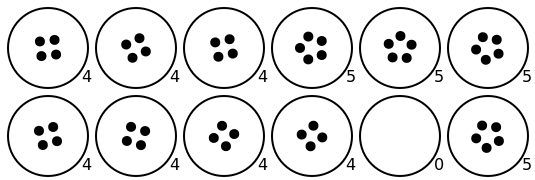

In [14]:
g = Game()  # Create a new game
g, captures, done = g.step(4)  # play the 5th pit (our implementation starts at 0)
g  # Display the resulting board inline

In [15]:
from __future__ import annotations
from typing import Optional, List
from weakref import ref, ReferenceType


@dataclass
class TreeGame(Game):
    # Hold an optional reference to the parent state
    parent: Optional[ReferenceType[Game]] = None
    # Hold a list of 6 optional references to the children
    children: List[Optional[Game]] = field(default_factory=lambda: [None] * 6)
    depth: int = 0

In [16]:
class TreeGame(TreeGame):
    ...

    def step(self, action):
        # If we already did compute the children node, just return it
        if self.children[action] is not None:
            new_game = self.children[action]
            captures = (
                new_game.captures[self.current_player]
                - self.captures[self.current_player]
            )
            return new_game, captures, new_game.game_finished
        # If not, call the original `step()` method and keep references in both directions
        else:
            new_game, captures, finished = super().step(action)
            new_game.parent = ref(self)
            new_game.depth = self.depth + 1
            self.children[action] = new_game
            return new_game, captures, finished

In [17]:
class TreeGame(TreeGame):
    ...

    @property
    def successors(self):
        children = [x for x in self.children if x is not None]
        successors = children + list(itertools.chain(*[x.successors for x in children]))
        return successors

    @property
    def unvisited_actions(self):
        return [i for i, x in enumerate(self.children) if x is None]

    @property
    def legal_unvisited_actions(self):
        return list(set(self.unvisited_actions).intersection(set(self.legal_actions)))

    @property
    def expanded_children(self):
        return [x for x in self.children if x is not None]

    @property
    def is_fully_expanded(self):
        legal_actions = set(self.legal_actions)
        unvisited_actions = set(self.unvisited_actions)
        return len(legal_actions.intersection(unvisited_actions)) == 0

    @property
    def is_leaf_game(self):
        return self.children == [None] * 6

In [19]:
class Player:
    def play(self, their_action):
        # If we are the first player, there is no previous action
        if their_action != -1:
            # Play the opponent's move
            self.root, _, _ = self.root.step(their_action)
        else:
            assert self.player_id == 0, "Only the first player can have their_action=-1"
        
        action = self.get_action()
        self.root, _, _ = self.root.step(action)
        
        return action

In [18]:
@dataclass
class TreeStatsGame(TreeGame):
    wins: np.array = field(default_factory=lambda: np.zeros(2, dtype=int))
    n_playouts: int = 0

    def update_stats(self, winner):
        if winner in [0, 1]:
            self.wins[winner] += 1
        self.n_playouts += 1
        if self.parent and self.parent():
            self.parent().update_stats(winner)

In [ ]:
class MCTSPlayer(Player):
    def __init__(self, player_id, budget: Union[int, timedelta]):
        self.root = TreeStatsGame()
        self.player_id = player_id
        self.budget = budget

    def tree_policy(self, node):
        while not node.is_leaf_game:
            if node.is_fully_expanded:
                node = random.choice(node.expanded_children)
            else:
                action = random.choice(node.legal_unvisited_actions)
                node, _, _ = node.step(action)
        return node
    
    def explore_tree(self):
        # Choose a starting node
        node = self.tree_policy(self.root)

        # Run a simulation on that node
        finished = node.game_finished
        while not finished:
            action = self.default_policy(node)
            node, _, finished = node.step(action)

        # Backtrack stats
        node.update_stats(node.winner)
    
    def default_policy(self, node):
        # Random walk
        return random.choice(node.legal_actions)
    
    def action_score(self, x):
        node = self.root.children[x]
        if node is None:
            return -random.random()

        assert self.root.current_player == self.player_id
        assert node.current_player != self.player_id

        return node.wins[self.player_id]
        
    
    def get_action(self):
        if isinstance(self.budget, int):
            for _ in range(self.budget):
                self.explore_tree()
        elif isinstance(self.budget, timedelta):
            start = datetime.now()
            end = start + self.budget
            while datetime.now() < end:
                self.explore_tree()
        else:
            raise TypeError("budget should be Union[int, timedelta], not %s" % type(budget))
        
        possible_actions = self.root.legal_actions
        return max(possible_actions, key=self.action_score)

In [ ]:
class RandomPlayer(Player):
    def __init__(self, player_id):
        self.root = Game()
        self.player_id = player_id
    
    def get_action(self):
        return random.choice(self.root.legal_actions)

In [ ]:
class GreedyPlayer(Player):
    def __init__(self, player_id, eps=0):
        self.root = Game()
        self.player_id = player_id
        self.eps = eps
    
    def get_action(self):
        # Choose a move
        children = []
        
        for legal_action in self.root.legal_actions:
            new_state, captures, finished = self.root.step(legal_action)
            if new_state.winner is None:
                win = 0
            elif new_state.winner == self.player_id:
                win = 1
            else:
                win = -1
            children.append((legal_action, captures, win))
        
        # order wins first, then by captures, then random
        sorted_children = sorted(children, key=lambda a_c_w: (-a_c_w[2], -a_c_w[1], random.random()))
        if random.random() < self.eps:
            action = random.choice(self.root.legal_actions)
        else:
            action = sorted_children[0][0]
            
        return action

In [ ]:
class UCTPlayer(MCTSPlayer):
    def __init__(self, player_id, budget: Union[int, timedelta], c: float):
        super().__init__(player_id, budget)
        self.c = c
        
    def node_score(self, node):
        exporation = node.wins[node.current_opponent] / (node.n_playouts + 1)
        exploitation = math.sqrt(math.log(node.parent().n_playouts) / (node.n_playouts + 1))
        return exporation + self.c * exploitation

    def tree_policy(self, node):
        while not node.is_leaf_game:
            if node.is_fully_expanded:
                node = max_rand(node.expanded_children, key=self.node_score)
            else:
                action = random.choice(node.legal_unvisited_actions)
                node, _, _ = node.step(action)
        return node

In [ ]:
class GreedyUCTPlayer(UCTPlayer):    
    def default_policy(self, node):
        # Greedy walk
        assert len(node.legal_actions) != 0
        captures = [node.step(action)[1] + 1 for action in node.legal_actions]
        return random.choices(node.legal_actions, weights=captures)[0]